In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/Test Descartes"

/content/drive/MyDrive/Test Descartes


Header description, why, how? 


In [75]:
#Import libraries
from sklearn.svm import SVC, LinearSVC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from  time import time
from sklearn.metrics import precision_score


In [77]:
# Import data 
Mean_DIR = "MEAN_AUTO.csv"
Shell_DIR = "SHELL_AUTO.csv" 
Test_DIR = "test_auto.csv"  
Train_DIR = "train_auto.csv"

Train_df = pd.read_csv(Train_DIR) 
Test_df = pd.read_csv(Test_DIR) 
Shell_df = pd.read_csv(Shell_DIR) #Real target value 
Mean_df = pd.read_csv(Mean_DIR) #Example of submission 



In [78]:
Train_df

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,10297,0,0.0,0,35.0,0,11.0,"$43,112",No,$0,z_No,M,z_High School,z_Blue Collar,51,Commercial,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
8157,10298,0,0.0,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,M,PhD,Manager,21,Private,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
8158,10299,0,0.0,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,M,Masters,NaN,36,Commercial,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban
8159,10301,0,0.0,0,50.0,0,7.0,"$43,445",No,"$149,248",Yes,z_F,Bachelors,Home Maker,36,Private,"$22,550",6,Minivan,no,$0,0,No,0,11.0,Highly Urban/ Urban


In [79]:
def clean_str_num(df, toClean):
  ######################################################
  #Input: 
      # df : data frame
      # col: columns to clean 

  # Output: df_clean
  # Description: removes "," "$" from columns in "col"
  ######################################################
  

   df_clean = df.copy()
   for col in toClean: 
     df_clean[col] = df[col].str.replace(',', '',regex=True).str.replace('$', '',regex=True).astype(float) 
   return df_clean


def categ_to_num(df,cat_columns): 
   #######################################################
   # Input: 
      # df : data frame
      # cat_columns: categorical columns 

  # Output: df_num
  # Description: Converts categorical variables to numerical codes
  ######################################################
   df_num = df.copy()
   df_num[cat_columns] = df_num[cat_columns].astype('category')
   df_num[cat_columns] = df_num[cat_columns].apply(lambda x: x.cat.codes)
   return df_num


#Clean "," and "$"
toClean = ["BLUEBOOK","INCOME","HOME_VAL", "BLUEBOOK","OLDCLAIM"]
df_clean, Test_clean = clean_str_num(Train_df, toClean), clean_str_num(Test_df, toClean)


#Convert categorical variables to numerical codes
cat_columns = df_clean.select_dtypes(['object']).columns
df_clean, Test_clean = categ_to_num(df_clean,cat_columns),categ_to_num(Test_clean,cat_columns)


In [80]:
df_clean

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,67349.0,0,0.0,1,0,3,5,14,1,14230.0,11,0,1,4461.0,2,0,3,18.0,0
1,2,0,0.0,0,43.0,0,11.0,91449.0,0,257252.0,1,0,4,7,22,0,14940.0,1,0,1,0.0,0,0,0,1.0,0
2,4,0,0.0,0,35.0,1,10.0,16039.0,0,124191.0,0,1,4,0,5,1,4010.0,4,5,0,38690.0,2,0,3,10.0,0
3,5,0,0.0,0,51.0,0,14.0,NaN,0,306251.0,0,0,0,7,32,1,15440.0,7,0,1,0.0,0,0,0,6.0,0
4,6,0,0.0,0,50.0,0,NaN,114986.0,0,243925.0,0,1,3,1,36,1,18000.0,1,5,0,19217.0,2,1,3,17.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,10297,0,0.0,0,35.0,0,11.0,43112.0,0,0.0,1,0,4,7,51,0,27330.0,10,1,1,0.0,0,0,0,8.0,1
8157,10298,0,0.0,1,45.0,2,9.0,164669.0,0,386273.0,0,0,3,4,21,1,13270.0,15,0,0,0.0,0,0,2,17.0,0
8158,10299,0,0.0,0,46.0,0,9.0,107204.0,0,332591.0,0,0,2,-1,36,0,24490.0,6,1,0,0.0,0,0,0,1.0,0
8159,10301,0,0.0,0,50.0,0,7.0,43445.0,0,149248.0,0,1,1,2,36,1,22550.0,6,0,0,0.0,0,0,0,11.0,0


#Corrolation between features
Which variables are most corrolated with the target label?

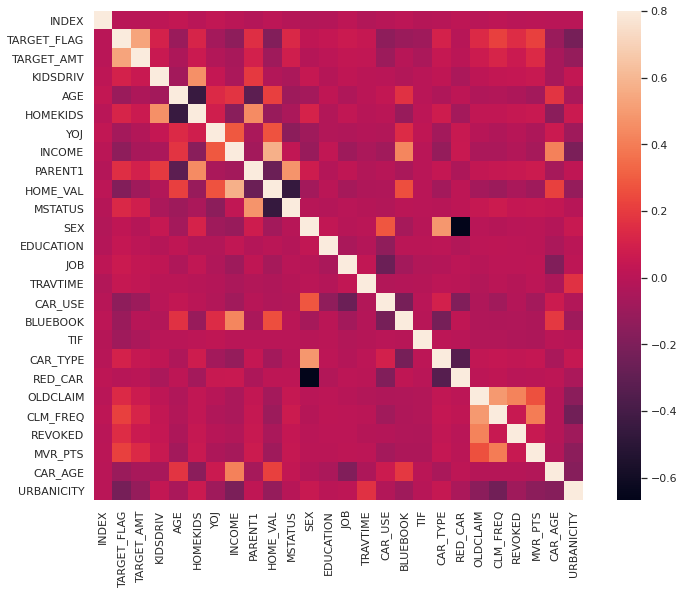

In [81]:
corrmat = df_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

=> CLM_FREQ & MVR_PTS are most corrolated with the target label.
Least corrolated is Urbanicity

In [82]:
df_clean['INCOME_band'] = pd.cut(df_clean['INCOME'], 10)
df_clean[['INCOME_band', 'TARGET_FLAG']].groupby(['INCOME_band'], as_index=False).mean().sort_values(by='INCOME_band', ascending=True)

,INCOME_band,TARGET_FLAG
0,"(-367.03, 36703.0]",0.330097
1,"(36703.0, 73406.0]",0.289269
2,"(73406.0, 110109.0]",0.180198
3,"(110109.0, 146812.0]",0.171617
4,"(146812.0, 183515.0]",0.169811
5,"(183515.0, 220218.0]",0.147826
6,"(220218.0, 256921.0]",0.102041
7,"(256921.0, 293624.0]",0.307692
8,"(293624.0, 330327.0]",0.250000
9,"(330327.0, 367030.0]",0.000000


=> Target_flag seems to be closer to 1 with very low incomes and and relatively large incomes

In [ ]:
df_clean.drop('INCOME_band', axis = 1, inplace=True)

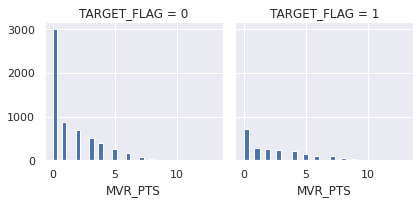

In [85]:
# Check if MVR_PTS has same distribution across classes
g = sns.FacetGrid(df_clean, col='TARGET_FLAG')
g.map(plt.hist, 'MVR_PTS', bins=30)

=> MVR_PTS has the same distribution across classes

In [86]:
df_clean[['SEX', 'TARGET_FLAG']].groupby(['SEX'], as_index=False).mean().sort_values(by='TARGET_FLAG', ascending=False)

,SEX,TARGET_FLAG
1,1,0.272457
0,0,0.253830


=> Sex variable makes no difference in Target_Flag

#Missing Data



*   How prevalent is the missing data?
*   Should we predict missing values or drop those columns/rows?




In [87]:
#Check missing values on train data
def missing_data(df_clean): 
   #######################################################
   # Input: 
      # df_clean : data frame
 
  # Output: Number and percentge of missing variables per feauture
  ######################################################
  total = df_clean.isnull().sum().sort_values(ascending=False)
  percent = (df_clean.isnull().sum()/df_clean.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data.head(20)

missing_data(df_clean)

,Total,Percent
CAR_AGE,510,0.062492
HOME_VAL,464,0.056856
YOJ,454,0.055630
INCOME,445,0.054528
AGE,6,0.000735
URBANICITY,0,0.000000
TARGET_FLAG,0,0.000000
TARGET_AMT,0,0.000000
KIDSDRIV,0,0.000000
HOMEKIDS,0,0.000000




*   Dropping missing features did not prove efficient. 
*   Missing data is not that commun between observations. 




In [88]:
# Predict missing values with a linear regression
my_imputer = IterativeImputer(max_iter=10, random_state=0)
df = my_imputer.fit_transform(df_clean)
df_clean[:]= my_imputer.transform(df)

missing_data(df_clean)

,Total,Percent
URBANICITY,0,0.0
CAR_AGE,0,0.0
TARGET_FLAG,0,0.0
TARGET_AMT,0,0.0
KIDSDRIV,0,0.0
AGE,0,0.0
HOMEKIDS,0,0.0
YOJ,0,0.0
INCOME,0,0.0
PARENT1,0,0.0


In [89]:
#Check missing values on test data
missing_data(Test_clean)


,Total,Percent
TARGET_FLAG,2141,1.000000
TARGET_AMT,2141,1.000000
CAR_AGE,129,0.060252
INCOME,125,0.058384
HOME_VAL,111,0.051845
YOJ,94,0.043905
AGE,1,0.000467
URBANICITY,0,0.000000
KIDSDRIV,0,0.000000
HOMEKIDS,0,0.000000


In [90]:
# predict missing values with a linear regression
my_imputer_t = IterativeImputer(max_iter=20, random_state=1)
Test_clean.drop(["TARGET_FLAG",	"TARGET_AMT"], axis = 1, inplace=True)
df = my_imputer_t.fit_transform(Test_clean)
Test_clean[:] = my_imputer_t.transform(df)

# Other ideas: In case we don't have the full training data, or predictions are done real time, 
#  we should replace missing data with the mean, or the  
#   value in the closest data point from the training data


In [91]:
missing_data(Test_clean)

,Total,Percent
URBANICITY,0,0.0
CAR_AGE,0,0.0
KIDSDRIV,0,0.0
AGE,0,0.0
HOMEKIDS,0,0.0
YOJ,0,0.0
INCOME,0,0.0
PARENT1,0,0.0
HOME_VAL,0,0.0
MSTATUS,0,0.0


In [ ]:
# col_drop = ["CAR_AGE","HOME_VAL", "YOJ", "INCOME","AGE"]
# for col in col_drop:
#   df_clean = df_clean.drop(df_clean.loc[df_clean[col].isnull()].index)

 => Dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better.

#Analyse Target_flag balance

In [92]:
# Check for classes balance
hist_class1 = df_clean.groupby(['TARGET_FLAG'])['INDEX'].count() 
hist_class1

TARGET_FLAG
0.0    6008
1.0    2153
Name: INDEX, dtype: int64

=> Unbalanced data

In [112]:
# Over sample minority by synthesizing new examples from the minority
# class to create a balanced dataset.

# Brief description: a random example from the minority class is first chosen. 
# Then k of the nearest neighbors for that example are found (typically k=5). 
#A randomly selected neighbor is chosen and a synthetic example is created at 
# a randomly selected point between the two examples in feature space.
sm = SMOTE() 
X_train, Y_train = sm.fit_sample(df_clean.drop(["TARGET_FLAG","TARGET_AMT"],1), df_clean["TARGET_FLAG"].ravel()) 


print("Class 0 :", sum(Y_train == 0))
print("Class 1 : ", sum(Y_train == 1))

Class 0 : 6008
Class 1 :  6008


#Predictions

In [113]:
#Verify shapes
X_test  = Test_clean.copy()
X_train.shape, Y_train.shape, X_test.shape

((12016, 24), (12016,), (2141, 24))

## Logistic regression as a baseline

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
logreg = LogisticRegression()

# X_train = X_train.reset_index()
# Y_train = Y_train.reset_index()


scores = cross_validate(logreg, X_train, Y_train, cv=5)

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp.fit(X_test)
#X_test = X_test.reset_index()

logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

59.71

In [115]:
scores["test_score"]

{'fit_time': array([0.12374759, 0.13112855, 0.12540865, 0.12589407, 0.06629181]),
 'score_time': array([0.00113463, 0.00095749, 0.00102234, 0.00096107, 0.00096464]),
 'test_score': array([0.58194676, 0.43279234, 0.60882231, 0.556804  , 0.41573034])}

In [ ]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

##Other models

In [149]:
#Support vector machines  
t0 = time()
svc = SVC()
scores = cross_validate(svc,X_train, Y_train, cv=5)
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print("done in %0.3fs" % (time() - t0))
acc_svc


done in 54.360s


59.55

In [119]:
scores["test_score"]

array([0.59775374, 0.56179775, 0.59051186, 0.58468581, 0.55930087])

In [ ]:
#73.59

In [121]:
#K neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
scores = cross_validate(knn,X_train, Y_train, cv=5)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

88.69

In [122]:
scores["test_score"]

array([0.71464226, 0.68872243, 0.73699542, 0.7457345 , 0.71826883])

In [125]:
#Decision_tree
decision_tree = DecisionTreeClassifier()
scores = cross_validate(decision_tree,X_train, Y_train, cv=5)

decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Training accouracy: ",acc_decision_tree) 

100.0

In [127]:
scores["test_score"]

array([0.37562396, 0.36620891, 0.81523096, 0.75863504, 0.47648772])

=> Decision trees are overfitting

In [128]:
random_forest = RandomForestClassifier(n_estimators=100)
scores = cross_validate(random_forest,X_train, Y_train, cv=5)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
Y_pred.to_csv(file_name, sep='\t')

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest


99.99

In [129]:
scores["test_score"]

array([0.49417637, 0.56054931, 0.88098211, 0.87473991, 0.50395339])

In [151]:
pd.DataFrame(Y_pred).to_csv("predictions.csv")


In [140]:
# XGboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 500, criterion = 'entropy',objective= "binary:logistic")
p_grid_XG = {'n_estimators': [700],"learning_rate": [0.01], "max_depth": [5] , 'min_samples_leaf': [3], "subsample": [0.9]} # I have left best parameters.
inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)
XG = GridSearchCV(estimator=xgb, param_grid=p_grid_XG, cv = inner_cv )

XG.fit(X_train, Y_train)
y_pred = XG.predict(X_train)
print("Best parameters": XG.best_params_)
print("Score : ",XG.score(X_train, Y_train))


{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 700, 'subsample': 0.9}
Score :  0.8873169107856191


In [142]:
from sklearn.metrics import precision_score
y_pred = XG.predict(X_train)
precision_score(Y_train, y_pred, average='macro')

0.8894438296319043

In [146]:
X_train.shape

(12016, 24)

No real labels have been given for the test data so I used training scores

In [130]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest',
                           'Decision Tree'],
    'Training Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, 
                acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,100.00
3,Random Forest,99.99
1,KNN,88.69
2,Logistic Regression,59.71
0,Support Vector Machines,59.55
